# 🤗 HuggingFace Neural Network Notebook

Sources:
1. [Originally based on cdoette's notebook](https://www.kaggle.com/code/cdeotte/deberta-v3-small-starter-cv-0-820-lb-0-800?scriptVersionId=174239814)

## Version History

### 1.0
Base implementation following [cdoette's notebook](https://www.kaggle.com/code/cdeotte/deberta-v3-small-starter-cv-0-820-lb-0-800?scriptVersionId=174239814)

### 2.0
1. Sliding window technique
2. wandb logging

## Setup

### Environment Variables

In [1]:
%env TOKENIZERS_PARALLELISM=true
%env WANDB_NOTEBOOK_NAME="neural_network.ipynb"

env: TOKENIZERS_PARALLELISM=true
env: WANDB_NOTEBOOK_NAME="neural_network.ipynb"


### Import Libraries

In [2]:
import gc
import os
import random
import time
from typing import Tuple, List
import warnings
import pickle as pkl

from dotenv import load_dotenv
import wandb
from tqdm import tqdm
import torch
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoConfig,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    PreTrainedTokenizer,
)
from datasets import Dataset
from tokenizers import AddedToken
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    cohen_kappa_score,
)

In [3]:
os.chdir("../")
warnings.simplefilter('ignore')
load_dotenv()

True

In [4]:
from lib.criterion.metrics import log_metrics
from lib.utils.find_threshold import find_thresholds

### Paths

In [5]:
class Paths:
    # Competition data with added topic column
    train_csv: str = "data/processed/train.csv"
    test_csv: str = "data/processed/test.csv"

    # Output path
    output_path: str = "output/model_dir"
    model_path: str = os.path.join(output_path, "{model_name}_fold_{fold}")
    tokenizer_path: str =  os.path.join(output_path, "{model_name}_tokenizer")
    oof_path: str = os.path.join(output_path, "valid_df_fold_{fold}.csv")
    threshold_path: str = os.path.join(output_path, "threshold.pkl")

### Configurations

In [6]:
DEBUG = False
DO_SLIDING_WINDOW = True
DO_REGRESSION = True

In [7]:
class CFG:
    backbone_model: str = "microsoft/deberta-v3-xsmall"
    gradient_accumulation_steps: int = 1
    gradient_checkpointing: bool = False
    lr: float = 1e-5
    max_length: int = 512
    n_splits: int = 7
    num_labels: int = 6
    num_folds: int = 7
    num_epochs: int = 3
    num_workers: int = 6
    seed: int = 20
    stride_length: int = 384
    train_batch_size: int = 32
    valid_batch_size: int = 32
    weight_decay: float = 0.01
    warmup_ratio: float = 0.01
    train_folds: List[int] = list(range(num_folds))

In [8]:
if DEBUG:
    CFG.num_epochs = 1
    CFG.train_folds = [0]

In [9]:
MODEL_NAME = CFG.backbone_model.split("/")[-1]

### Setting Random Seed

In [10]:
def seed_everything() -> None:
    """Seed everything to ensure reproducibility

    Sources:
    1. https://www.kaggle.com/code/alejopaullier/aes-2-multi-class-classification-train
    2. https://www.kaggle.com/code/hashidoyuto/deberta-baseline-aes2-0-train
    """
    random.seed(CFG.seed)
    os.environ["PYTHONHASHCFG.SEED"] = str(CFG.seed)
    np.random.seed(CFG.seed)
    torch.manual_seed(CFG.seed)
    torch.cuda.manual_seed(CFG.seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything()

### WandB setup

In [11]:
WANDB_PROJECT = "Kaggle_ASE_2.0"
model_name = CFG.backbone_model.split("/")[-1]
type = "R" if DO_REGRESSION else "C"
WANDB_NAME = f"{model_name}-{CFG.max_length}-{type}"

In [12]:
wandb.login(key=os.environ.get('WANDB_API_KEY'))
wandb.init(
    project=WANDB_PROJECT,
    name=WANDB_NAME,
    save_code=True,
    job_type="train",
)
config = wandb.config

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find "neural_network.ipynb".
wandb: Currently logged in as: shakleenishfar (laplacesdemon43). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/ishfar/.netrc


## Data Preparation

### Tokenizer

In [13]:
class Tokenize(object):
    def __init__(self, train, valid, tokenizer):
        self.tokenizer = tokenizer
        self.train = train
        self.valid = valid

    def get_dataset(self, df):
        ds = Dataset.from_dict(
            {
                "essay_id": [e for e in df["essay_id"]],
                "full_text": [ft for ft in df["full_text"]],
                "score": [s for s in df["score"]],
            }
        )
        return ds

    def tokenize_function(self, example):
        tokenized_inputs = self.tokenizer(
            example["full_text"],
            truncation=True,
            max_length=CFG.max_length,
            padding="max_length",
            
        )
        return tokenized_inputs

    def __call__(self):
        train_ds = self.get_dataset(self.train)
        valid_ds = self.get_dataset(self.valid)

        tokenized_train = train_ds.map(self.tokenize_function, batched=True)
        tokenized_valid = valid_ds.map(self.tokenize_function, batched=True)

        return tokenized_train, tokenized_valid, self.tokenizer

In [14]:
tokenizer = AutoTokenizer.from_pretrained(CFG.backbone_model)
tokenizer.add_tokens([AddedToken("\n", normalized=False)])
tokenizer.add_tokens([AddedToken(" " * 2, normalized=False)])
tokenizer.save_pretrained(Paths.tokenizer_path.format(model_name=MODEL_NAME))

('output/model_dir/deberta-v3-xsmall_tokenizer/tokenizer_config.json',
 'output/model_dir/deberta-v3-xsmall_tokenizer/special_tokens_map.json',
 'output/model_dir/deberta-v3-xsmall_tokenizer/spm.model',
 'output/model_dir/deberta-v3-xsmall_tokenizer/added_tokens.json',
 'output/model_dir/deberta-v3-xsmall_tokenizer/tokenizer.json')

### Data Preprocessing

1. Convert `labels` to be in `scores` which are processed to be in range $[0-5]$.
2. Convert `label` data type based on whether we are doing regression or classification.

In [15]:
data = pd.read_csv(Paths.train_csv, low_memory=False)
print("Training dataset has shape:", data.shape)

data["score"] = data["score"].map(lambda x: x- 1)

if DO_REGRESSION:
    data["score"] = data["score"].astype(pd.Float32Dtype())
else:
    data["score"] = data["score"].astype(pd.Int32Dtype())

data.head(3)

Training dataset has shape: (17307, 4)


,essay_id,full_text,score,topic,label
0,000d118,Many people have car where they live. The thin...,3,5,2.0
1,000fe60,I am a scientist at NASA that is discussing th...,3,3,2.0
2,001ab80,People always wish they had the same technolog...,4,0,3.0


### CV Fold Generation

Split training data into `CFG.num_folds` number of distinct CV folds.

In [16]:
skf = StratifiedGroupKFold(n_splits=CFG.num_folds, shuffle=True, random_state=CFG.seed)

for i, (_, val_index) in enumerate(skf.split(data, data["score"], data["topic"])):
    data.loc[val_index, "fold"] = i

data.head()

,essay_id,full_text,score,topic,label,fold
0,000d118,Many people have car where they live. The thin...,3,5,2.0,1.0
1,000fe60,I am a scientist at NASA that is discussing th...,3,3,2.0,5.0
2,001ab80,People always wish they had the same technolog...,4,0,3.0,4.0
3,001bdc0,"We all heard about Venus, the planet without a...",4,2,3.0,0.0
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3,4,2.0,6.0


### Sliding Window

Essays can have varying lengths. Instead of truncating, see the entire essay as windows of length `CFG.max_length` which are strided with `CFG.stride_length`.

In [17]:
def construct_new_row(old_row, text):
    new_row = {key: old_row[key] for key in old_row.keys() if key != "index"}
    new_row["full_text"] = text
    return new_row

In [18]:
def split_tokens(tokens, stride):
    """Splits `tokens` into multiple sequences that have at most
    `CFG.max_length` tokens. Uses `CFG.stride` for sliding
    window.

    Args:
        tokens (List): List of tokens.
        stride (int): Stride length.

    Returns:
        List[List[int]]: List of split token sequences.
    """
    start = 0
    sequence_list = []

    while start < len(tokens):
        remaining_tokens = len(tokens) - start

        if remaining_tokens < CFG.max_length and start > 0:
            start = max(0, len(tokens) - CFG.max_length)

        end = min(start + CFG.max_length, len(tokens))
        sequence_list.append(tokens[start:end])

        if remaining_tokens >= CFG.max_length:
            start += stride
        else:
            break

    return sequence_list

In [19]:
def sliding_window(df, tokenizer):
    """Splits rows of `df` so that each row's text has at most
    `CFG.max_length` number of tokens.

    Args:
        df (pd.DataFrame): Input data frame.
        tokenizer (_type_): Tokenizer used to encode and decode text.

    Returns:
        pd.DataFrame: Newly constructed dataframe.
    """

    new_df = []

    for _, row in tqdm(df.iterrows(), total=df.shape[0]):
        tokens = tokenizer.encode(row["full_text"], add_special_tokens=False)

        if len(tokens) <= CFG.max_length:
            new_df.append(construct_new_row(row, row["full_text"]))
        else:
            sequence_list = split_tokens(tokens, CFG.stride_length)

            for seq in sequence_list:
                new_df.append(
                    construct_new_row(
                        row,
                        tokenizer.decode(seq, skip_special_tokens=True),
                    )
                )

    return pd.DataFrame(new_df)

In [20]:
if DO_SLIDING_WINDOW:
    data = sliding_window(data, tokenizer)
    data.head(3)

100%|██████████| 17307/17307 [00:30<00:00, 565.56it/s]


## Metrics

### QWK Score Calculation

In [21]:
def compute_metrics_for_regression(eval_pred):
    predictions, labels = eval_pred

    qwk = cohen_kappa_score(
        labels,
        predictions.clip(0, 5).round(0),
        weights="quadratic",
    )

    return {"qwk": qwk}

In [22]:
def compute_metrics_for_classification(eval_pred):
    predictions, labels = eval_pred

    qwk = cohen_kappa_score(
        labels,
        predictions.argmax(-1),
        weights="quadratic",
    )
    
    return {"qwk": qwk}

In [23]:
if DO_REGRESSION:
    compute_metrics = compute_metrics_for_regression
else:
    compute_metrics = compute_metrics_for_classification

### WandB Metric Logging

In [24]:
def plot_wandb_bar(data, label, value, id, title):
    table = wandb.Table(data=data, columns=[label, value])
    wandb.log({id: wandb.plot.bar(table, label, value, title=title)})

In [25]:
def plot_metrics(prefix, precision_data, recall_data, f1_data):
    plot_wandb_bar(
        f1_data,
        "score",
        "F1 Score",
        f"{prefix}/F1 Score",
        f"F1 score for {prefix}",
    )
    plot_wandb_bar(
        recall_data,
        "score",
        "Recall",
        f"{prefix}/Recall",
        f"Recall for {prefix}",
    )
    plot_wandb_bar(
        precision_data,
        "score",
        "Precision",
        f"{prefix}/Precision",
        f"Precision for {prefix}",
    )

In [26]:
def calcluate_metrics(df):
    precision_data = [None for _ in range(CFG.num_labels)]
    recall_data = [None for _ in range(CFG.num_labels)]
    f1_data = [None for _ in range(CFG.num_labels)]

    for score in range(CFG.num_labels):
        tp = df.loc[(df.score == score) & (df.score == df.pred_score), "score"].count()
        fp = df.loc[(df.score != score) & (df.pred_score == score), "score"].count()
        tn = df.loc[(df.score != score) & (df.pred_score != score), "score"].count()
        fn = df.loc[(df.score == score) & (df.pred_score != score), "score"].count()

        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1 = (2 * precision * recall) / (precision + recall)

        precision_data[score] = (score, precision)
        recall_data[score] = (score, recall)
        f1_data[score] = (score, f1)

    return precision_data, recall_data, f1_data

In [49]:
def log_metrics(df, prefix):
    wandb.log(
        {
            f"{prefix}/conf_mat": wandb.plot.confusion_matrix(
                probs=None,
                y_true=df["score"].astype(pd.Int32Dtype()),
                preds=df["pred_score"].astype(pd.Int32Dtype()),
                class_names=list(range(CFG.num_labels)),
            )
        }
    )

    precision_data, recall_data, f1_data = calcluate_metrics(df)
    plot_metrics(prefix, precision_data, recall_data, f1_data)

## Training

### Training Arguments

In [28]:
training_args = TrainingArguments(
    data_seed=CFG.seed,
    dataloader_num_workers=CFG.num_workers,
    evaluation_strategy="epoch",
    fp16=True,
    gradient_checkpointing=CFG.gradient_checkpointing,
    gradient_accumulation_steps=CFG.gradient_accumulation_steps,
    learning_rate=CFG.lr,
    load_best_model_at_end=True,
    logging_first_step=True,
    logging_steps=50,
    lr_scheduler_type="linear",
    metric_for_best_model="qwk",
    num_train_epochs=CFG.num_epochs,
    output_dir=Paths.output_path,
    optim="adamw_torch",
    per_device_eval_batch_size=CFG.valid_batch_size,
    per_device_train_batch_size=CFG.train_batch_size,
    report_to="wandb",
    save_strategy="epoch",
    save_total_limit=1,
    weight_decay=CFG.weight_decay,
    warmup_ratio=CFG.warmup_ratio,
)

### Utility Functions

In [29]:
def get_fold_data(fold: int) -> Tuple[pd.DataFrame, pd.DataFrame]:
    train = data[data["fold"] != fold].reset_index(drop=True)
    valid = data[data["fold"] == fold].reset_index(drop=True)
    return train, valid

In [30]:
def tokenize_data(train: pd.DataFrame, valid: pd.DataFrame) -> Tuple[Dataset, Dataset]:
    tokenize = Tokenize(train, valid, tokenizer)
    tokenized_train, tokenized_valid, _ = tokenize()
    return tokenized_train, tokenized_valid

In [31]:
def configure():
    config = AutoConfig.from_pretrained(CFG.backbone_model)
    
    if DO_REGRESSION:
        config.attention_probs_dropout_prob = 0.0
        config.hidden_dropout_prob = 0.0
        config.num_labels = 1
    else:
        config.num_labels = CFG.num_labels

    return config

In [32]:
def get_model(config):
    backbone_model = AutoModelForSequenceClassification.from_pretrained(
        CFG.backbone_model,
        config=config,
    )
    backbone_model.resize_token_embeddings(len(tokenizer))
    return backbone_model

In [33]:
def post_process_predictions(predictions0):
    if DO_REGRESSION:
        predictions = predictions0.clip(0, 5).round(0)
    else:
        predictions = predictions0.argmax(axis=1)

    return predictions

In [34]:
def plot_confusion_matrxi(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[x for x in range(CFG.num_labels)])
    draw_cm = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=[x for x in range(CFG.num_labels)]
    )
    draw_cm.plot()
    plt.show()

In [35]:
def save_model_and_tokenizer(fold: int, trainer: Trainer):
    trainer.save_model(Paths.model_path.format(model_name=MODEL_NAME, fold=fold))

In [36]:
def save_oof_predictions(fold, valid, logits, y_pred):
    if DO_REGRESSION:
        valid["pred"] = logits
    else:
        COLS = [f"p{x}" for x in range(CFG.num_labels)]
        valid[COLS] = logits

    valid["pred_score"] = y_pred
    valid.to_csv(Paths.oof_path.format(fold=fold), index=False)
    return valid

### Training Fold Loop

In [37]:
scores = []

for fold in CFG.train_folds:
    train, valid = get_fold_data(fold)

    tokenized_train, tokenized_valid = tokenize_data(train, valid)

    config = configure()

    backbone_model = get_model(config)

    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    trainer = Trainer(
        model=backbone_model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_valid,
        data_collator=data_collator,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )

    trainer.train()

    y_true = valid["score"].values
    logits = trainer.predict(tokenized_valid).predictions
    y_pred = post_process_predictions(logits)

    save_model_and_tokenizer(fold, trainer)

    oof_df = save_oof_predictions(fold, valid, logits, y_pred)
    score = compute_metrics((oof_df["pred_score"], oof_df["score"]))
    log_metrics(oof_df, f"Fold {fold}")

    del (
        train,
        valid,
        tokenized_train,
        tokenized_valid,
        backbone_model,
        data_collator,
        trainer,
        y_pred,
        y_true,
        logits,
    )
    gc.collect()
    torch.cuda.empty_cache()
    time.sleep(5)

Map:   0%|          | 0/18959 [00:00<?, ? examples/s]

Map:   0%|          | 0/3788 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-xsmall and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/1779 [00:00<?, ?it/s]

{'loss': 6.4536, 'grad_norm': inf, 'learning_rate': 0.0, 'epoch': 0.0}
{'loss': 5.0442, 'grad_norm': 24.768970489501953, 'learning_rate': 9.835320840431574e-06, 'epoch': 0.08}
{'loss': 1.2324, 'grad_norm': 21.341154098510742, 'learning_rate': 9.551391254968769e-06, 'epoch': 0.17}
{'loss': 0.5817, 'grad_norm': 4.850841045379639, 'learning_rate': 9.267461669505964e-06, 'epoch': 0.25}
{'loss': 0.4782, 'grad_norm': 16.736303329467773, 'learning_rate': 8.983532084043158e-06, 'epoch': 0.34}
{'loss': 0.508, 'grad_norm': 2.9447059631347656, 'learning_rate': 8.699602498580353e-06, 'epoch': 0.42}
{'loss': 0.4547, 'grad_norm': 6.971384525299072, 'learning_rate': 8.415672913117548e-06, 'epoch': 0.51}
{'loss': 0.4711, 'grad_norm': 6.1995649337768555, 'learning_rate': 8.131743327654743e-06, 'epoch': 0.59}
{'loss': 0.4695, 'grad_norm': 23.73298454284668, 'learning_rate': 7.847813742191937e-06, 'epoch': 0.67}
{'loss': 0.4913, 'grad_norm': 18.219816207885742, 'learning_rate': 7.563884156729132e-06, 'ep

  0%|          | 0/119 [00:00<?, ?it/s]

{'eval_loss': 0.4973083436489105, 'eval_qwk': 0.7043003105420098, 'eval_runtime': 10.3367, 'eval_samples_per_second': 366.461, 'eval_steps_per_second': 11.512, 'epoch': 1.0}
{'loss': 0.4394, 'grad_norm': 6.097761154174805, 'learning_rate': 6.7120954003407155e-06, 'epoch': 1.01}
{'loss': 0.4067, 'grad_norm': 10.36308765411377, 'learning_rate': 6.428165814877911e-06, 'epoch': 1.1}
{'loss': 0.3775, 'grad_norm': 3.202192544937134, 'learning_rate': 6.144236229415106e-06, 'epoch': 1.18}
{'loss': 0.3934, 'grad_norm': 11.353994369506836, 'learning_rate': 5.860306643952301e-06, 'epoch': 1.26}
{'loss': 0.3876, 'grad_norm': 8.909263610839844, 'learning_rate': 5.576377058489495e-06, 'epoch': 1.35}
{'loss': 0.3946, 'grad_norm': 2.8031423091888428, 'learning_rate': 5.292447473026689e-06, 'epoch': 1.43}
{'loss': 0.3936, 'grad_norm': 17.602174758911133, 'learning_rate': 5.008517887563884e-06, 'epoch': 1.52}
{'loss': 0.3974, 'grad_norm': 15.282307624816895, 'learning_rate': 4.724588302101079e-06, 'epoc

  0%|          | 0/119 [00:00<?, ?it/s]

{'eval_loss': 0.4652891755104065, 'eval_qwk': 0.7712786075173999, 'eval_runtime': 10.3775, 'eval_samples_per_second': 365.021, 'eval_steps_per_second': 11.467, 'epoch': 2.0}
{'loss': 0.3588, 'grad_norm': 5.505379676818848, 'learning_rate': 3.304940374787053e-06, 'epoch': 2.02}
{'loss': 0.3561, 'grad_norm': 10.830266952514648, 'learning_rate': 3.021010789324248e-06, 'epoch': 2.11}
{'loss': 0.3477, 'grad_norm': 8.034802436828613, 'learning_rate': 2.7370812038614424e-06, 'epoch': 2.19}
{'loss': 0.3325, 'grad_norm': 3.705263137817383, 'learning_rate': 2.453151618398637e-06, 'epoch': 2.28}
{'loss': 0.3545, 'grad_norm': 7.2719831466674805, 'learning_rate': 2.1692220329358323e-06, 'epoch': 2.36}
{'loss': 0.3364, 'grad_norm': 8.286696434020996, 'learning_rate': 1.8852924474730268e-06, 'epoch': 2.45}
{'loss': 0.3487, 'grad_norm': 11.411486625671387, 'learning_rate': 1.6013628620102218e-06, 'epoch': 2.53}
{'loss': 0.314, 'grad_norm': 3.7926485538482666, 'learning_rate': 1.3174332765474163e-06, '

  0%|          | 0/119 [00:00<?, ?it/s]

{'eval_loss': 0.4798564314842224, 'eval_qwk': 0.7523406336427481, 'eval_runtime': 10.3665, 'eval_samples_per_second': 365.407, 'eval_steps_per_second': 11.479, 'epoch': 3.0}
{'train_runtime': 571.1968, 'train_samples_per_second': 99.575, 'train_steps_per_second': 3.115, 'train_loss': 0.5480605050913064, 'epoch': 3.0}


  0%|          | 0/119 [00:00<?, ?it/s]

Map:   0%|          | 0/19638 [00:00<?, ? examples/s]

Map:   0%|          | 0/3109 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-xsmall and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/1842 [00:00<?, ?it/s]

{'loss': 5.7354, 'grad_norm': inf, 'learning_rate': 0.0, 'epoch': 0.0}
{'loss': 4.9781, 'grad_norm': 26.034202575683594, 'learning_rate': 9.851892484914976e-06, 'epoch': 0.08}
{'loss': 1.3344, 'grad_norm': 12.234821319580078, 'learning_rate': 9.577619308831597e-06, 'epoch': 0.16}
{'loss': 0.5957, 'grad_norm': 2.4587900638580322, 'learning_rate': 9.303346132748218e-06, 'epoch': 0.24}
{'loss': 0.5011, 'grad_norm': 15.084223747253418, 'learning_rate': 9.02907295666484e-06, 'epoch': 0.33}
{'loss': 0.4851, 'grad_norm': 14.389272689819336, 'learning_rate': 8.75479978058146e-06, 'epoch': 0.41}
{'loss': 0.4633, 'grad_norm': 17.77237319946289, 'learning_rate': 8.48052660449808e-06, 'epoch': 0.49}
{'loss': 0.4615, 'grad_norm': 6.302544593811035, 'learning_rate': 8.206253428414702e-06, 'epoch': 0.57}
{'loss': 0.408, 'grad_norm': 11.729401588439941, 'learning_rate': 7.931980252331323e-06, 'epoch': 0.65}
{'loss': 0.4102, 'grad_norm': 14.19947624206543, 'learning_rate': 7.657707076247943e-06, 'epoch

  0%|          | 0/98 [00:00<?, ?it/s]

{'eval_loss': 0.5362098217010498, 'eval_qwk': 0.6293127887752521, 'eval_runtime': 8.6454, 'eval_samples_per_second': 359.615, 'eval_steps_per_second': 11.336, 'epoch': 1.0}
{'loss': 0.392, 'grad_norm': 5.670067310333252, 'learning_rate': 6.560614371914428e-06, 'epoch': 1.06}
{'loss': 0.3953, 'grad_norm': 6.965231895446777, 'learning_rate': 6.2863411958310485e-06, 'epoch': 1.14}
{'loss': 0.3985, 'grad_norm': 8.503127098083496, 'learning_rate': 6.012068019747669e-06, 'epoch': 1.22}
{'loss': 0.3666, 'grad_norm': 3.5302844047546387, 'learning_rate': 5.73779484366429e-06, 'epoch': 1.3}
{'loss': 0.3627, 'grad_norm': 3.4339332580566406, 'learning_rate': 5.463521667580911e-06, 'epoch': 1.38}
{'loss': 0.3669, 'grad_norm': 3.832585334777832, 'learning_rate': 5.189248491497532e-06, 'epoch': 1.47}
{'loss': 0.348, 'grad_norm': 4.805006980895996, 'learning_rate': 4.914975315414152e-06, 'epoch': 1.55}
{'loss': 0.3465, 'grad_norm': 22.652751922607422, 'learning_rate': 4.640702139330774e-06, 'epoch': 1

  0%|          | 0/98 [00:00<?, ?it/s]

{'eval_loss': 0.6384896039962769, 'eval_qwk': 0.6505208903960831, 'eval_runtime': 8.5732, 'eval_samples_per_second': 362.642, 'eval_steps_per_second': 11.431, 'epoch': 2.0}
{'loss': 0.3458, 'grad_norm': 10.084320068359375, 'learning_rate': 3.2693362589138785e-06, 'epoch': 2.04}
{'loss': 0.3476, 'grad_norm': 4.202254772186279, 'learning_rate': 2.9950630828304993e-06, 'epoch': 2.12}
{'loss': 0.3301, 'grad_norm': 10.325106620788574, 'learning_rate': 2.7207899067471206e-06, 'epoch': 2.2}
{'loss': 0.3245, 'grad_norm': 9.253069877624512, 'learning_rate': 2.4465167306637415e-06, 'epoch': 2.28}
{'loss': 0.3253, 'grad_norm': 3.800105571746826, 'learning_rate': 2.1722435545803624e-06, 'epoch': 2.36}
{'loss': 0.364, 'grad_norm': 10.006180763244629, 'learning_rate': 1.897970378496983e-06, 'epoch': 2.44}
{'loss': 0.3336, 'grad_norm': 5.201859474182129, 'learning_rate': 1.623697202413604e-06, 'epoch': 2.52}
{'loss': 0.3244, 'grad_norm': 3.7484042644500732, 'learning_rate': 1.349424026330225e-06, 'ep

  0%|          | 0/98 [00:00<?, ?it/s]

{'eval_loss': 0.5926254391670227, 'eval_qwk': 0.6608887029727817, 'eval_runtime': 8.5753, 'eval_samples_per_second': 362.552, 'eval_steps_per_second': 11.428, 'epoch': 3.0}
{'train_runtime': 584.4051, 'train_samples_per_second': 100.81, 'train_steps_per_second': 3.152, 'train_loss': 0.5319512333077794, 'epoch': 3.0}


  0%|          | 0/98 [00:00<?, ?it/s]

Map:   0%|          | 0/18892 [00:00<?, ? examples/s]

wandb: Network error resolved after 0:00:01.118019, resuming normal operation.


Map:   0%|          | 0/3855 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-xsmall and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/1773 [00:00<?, ?it/s]

{'loss': 5.1285, 'grad_norm': inf, 'learning_rate': 0.0, 'epoch': 0.0}
{'loss': 4.8598, 'grad_norm': 27.28614044189453, 'learning_rate': 9.840455840455842e-06, 'epoch': 0.08}
{'loss': 1.2928, 'grad_norm': 10.213499069213867, 'learning_rate': 9.555555555555556e-06, 'epoch': 0.17}
{'loss': 0.6255, 'grad_norm': 13.471131324768066, 'learning_rate': 9.270655270655271e-06, 'epoch': 0.25}
{'loss': 0.5172, 'grad_norm': 15.413372039794922, 'learning_rate': 8.985754985754986e-06, 'epoch': 0.34}
{'loss': 0.5014, 'grad_norm': 9.377862930297852, 'learning_rate': 8.700854700854702e-06, 'epoch': 0.42}
{'loss': 0.5634, 'grad_norm': 9.463191986083984, 'learning_rate': 8.415954415954417e-06, 'epoch': 0.51}
{'loss': 0.4205, 'grad_norm': 13.876293182373047, 'learning_rate': 8.131054131054132e-06, 'epoch': 0.59}
{'loss': 0.4482, 'grad_norm': 11.648027420043945, 'learning_rate': 7.846153846153847e-06, 'epoch': 0.68}
{'loss': 0.4539, 'grad_norm': 10.605575561523438, 'learning_rate': 7.561253561253562e-06, 'e

  0%|          | 0/121 [00:00<?, ?it/s]

{'eval_loss': 0.495753675699234, 'eval_qwk': 0.7443643124028737, 'eval_runtime': 10.5635, 'eval_samples_per_second': 364.937, 'eval_steps_per_second': 11.455, 'epoch': 1.0}
{'loss': 0.4386, 'grad_norm': 4.872735977172852, 'learning_rate': 6.706552706552707e-06, 'epoch': 1.02}
{'loss': 0.4365, 'grad_norm': 6.956718921661377, 'learning_rate': 6.421652421652422e-06, 'epoch': 1.1}
{'loss': 0.4025, 'grad_norm': 15.742267608642578, 'learning_rate': 6.136752136752138e-06, 'epoch': 1.18}
{'loss': 0.3992, 'grad_norm': 2.787698268890381, 'learning_rate': 5.8518518518518515e-06, 'epoch': 1.27}
{'loss': 0.3934, 'grad_norm': 6.7583909034729, 'learning_rate': 5.566951566951567e-06, 'epoch': 1.35}
{'loss': 0.3886, 'grad_norm': 11.214531898498535, 'learning_rate': 5.282051282051283e-06, 'epoch': 1.44}
{'loss': 0.3819, 'grad_norm': 8.932510375976562, 'learning_rate': 4.997150997150997e-06, 'epoch': 1.52}
{'loss': 0.3583, 'grad_norm': 5.082554340362549, 'learning_rate': 4.712250712250713e-06, 'epoch': 1

  0%|          | 0/121 [00:00<?, ?it/s]

{'eval_loss': 0.44104263186454773, 'eval_qwk': 0.7703400938930614, 'eval_runtime': 10.5589, 'eval_samples_per_second': 365.096, 'eval_steps_per_second': 11.46, 'epoch': 2.0}
{'loss': 0.3561, 'grad_norm': 12.180912017822266, 'learning_rate': 3.287749287749288e-06, 'epoch': 2.03}
{'loss': 0.3409, 'grad_norm': 7.022983074188232, 'learning_rate': 3.002849002849003e-06, 'epoch': 2.12}
{'loss': 0.3536, 'grad_norm': 15.384184837341309, 'learning_rate': 2.717948717948718e-06, 'epoch': 2.2}
{'loss': 0.3698, 'grad_norm': 4.313325881958008, 'learning_rate': 2.4330484330484334e-06, 'epoch': 2.28}
{'loss': 0.3541, 'grad_norm': 4.016149044036865, 'learning_rate': 2.148148148148148e-06, 'epoch': 2.37}
{'loss': 0.342, 'grad_norm': 3.1563053131103516, 'learning_rate': 1.8632478632478635e-06, 'epoch': 2.45}
{'loss': 0.3532, 'grad_norm': 6.856785297393799, 'learning_rate': 1.5783475783475785e-06, 'epoch': 2.54}
{'loss': 0.3475, 'grad_norm': 9.346049308776855, 'learning_rate': 1.2934472934472936e-06, 'epo

  0%|          | 0/121 [00:00<?, ?it/s]

{'eval_loss': 0.4336632788181305, 'eval_qwk': 0.7774519917997633, 'eval_runtime': 10.5569, 'eval_samples_per_second': 365.163, 'eval_steps_per_second': 11.462, 'epoch': 3.0}
{'train_runtime': 569.4439, 'train_samples_per_second': 99.529, 'train_steps_per_second': 3.114, 'train_loss': 0.5537921305235267, 'epoch': 3.0}


  0%|          | 0/121 [00:00<?, ?it/s]

Map:   0%|          | 0/20923 [00:00<?, ? examples/s]

Map:   0%|          | 0/1824 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-xsmall and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/1962 [00:00<?, ?it/s]

{'loss': 4.1697, 'grad_norm': inf, 'learning_rate': 0.0, 'epoch': 0.0}
{'loss': 5.4975, 'grad_norm': 26.560649871826172, 'learning_rate': 9.866117404737386e-06, 'epoch': 0.08}
{'loss': 1.2924, 'grad_norm': 25.169509887695312, 'learning_rate': 9.608650875386201e-06, 'epoch': 0.15}
{'loss': 0.5727, 'grad_norm': 11.371573448181152, 'learning_rate': 9.351184346035016e-06, 'epoch': 0.23}
{'loss': 0.5461, 'grad_norm': 4.874536514282227, 'learning_rate': 9.093717816683832e-06, 'epoch': 0.31}
{'loss': 0.5129, 'grad_norm': 6.5302605628967285, 'learning_rate': 8.836251287332647e-06, 'epoch': 0.38}
{'loss': 0.5145, 'grad_norm': 11.758444786071777, 'learning_rate': 8.578784757981463e-06, 'epoch': 0.46}
{'loss': 0.5217, 'grad_norm': 32.2769889831543, 'learning_rate': 8.321318228630278e-06, 'epoch': 0.54}
{'loss': 0.4845, 'grad_norm': 19.232492446899414, 'learning_rate': 8.063851699279093e-06, 'epoch': 0.61}
{'loss': 0.4384, 'grad_norm': 11.500768661499023, 'learning_rate': 7.80638516992791e-06, 'ep

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.416547030210495, 'eval_qwk': 0.5735235586041102, 'eval_runtime': 5.1681, 'eval_samples_per_second': 352.933, 'eval_steps_per_second': 11.029, 'epoch': 1.0}
{'loss': 0.4354, 'grad_norm': 5.359321594238281, 'learning_rate': 6.519052523171988e-06, 'epoch': 1.07}
{'loss': 0.3972, 'grad_norm': 5.696270942687988, 'learning_rate': 6.2615859938208035e-06, 'epoch': 1.15}
{'loss': 0.4158, 'grad_norm': 10.71346378326416, 'learning_rate': 6.00411946446962e-06, 'epoch': 1.22}
{'loss': 0.3659, 'grad_norm': 3.751483678817749, 'learning_rate': 5.746652935118435e-06, 'epoch': 1.3}
{'loss': 0.3631, 'grad_norm': 7.472462177276611, 'learning_rate': 5.4891864057672505e-06, 'epoch': 1.38}
{'loss': 0.3884, 'grad_norm': 23.70863151550293, 'learning_rate': 5.231719876416066e-06, 'epoch': 1.45}
{'loss': 0.3898, 'grad_norm': 4.275477409362793, 'learning_rate': 4.974253347064882e-06, 'epoch': 1.53}
{'loss': 0.3916, 'grad_norm': 7.2317891120910645, 'learning_rate': 4.7167868177136975e-06, 'epoch': 

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.47169896960258484, 'eval_qwk': 0.511547141179457, 'eval_runtime': 5.1428, 'eval_samples_per_second': 354.669, 'eval_steps_per_second': 11.083, 'epoch': 2.0}
{'loss': 0.3732, 'grad_norm': 20.277578353881836, 'learning_rate': 3.1719876416065915e-06, 'epoch': 2.06}
{'loss': 0.3451, 'grad_norm': 17.780162811279297, 'learning_rate': 2.914521112255407e-06, 'epoch': 2.14}
{'loss': 0.3517, 'grad_norm': 3.701826572418213, 'learning_rate': 2.6570545829042226e-06, 'epoch': 2.22}
{'loss': 0.3448, 'grad_norm': 4.307116508483887, 'learning_rate': 2.3995880535530384e-06, 'epoch': 2.29}
{'loss': 0.3416, 'grad_norm': 7.405353546142578, 'learning_rate': 2.142121524201854e-06, 'epoch': 2.37}
{'loss': 0.3195, 'grad_norm': 5.9387993812561035, 'learning_rate': 1.8846549948506696e-06, 'epoch': 2.45}
{'loss': 0.3569, 'grad_norm': 10.613525390625, 'learning_rate': 1.6271884654994852e-06, 'epoch': 2.52}
{'loss': 0.3565, 'grad_norm': 18.92848777770996, 'learning_rate': 1.3697219361483008e-06, 'ep

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.45872604846954346, 'eval_qwk': 0.5419256125994221, 'eval_runtime': 5.1698, 'eval_samples_per_second': 352.82, 'eval_steps_per_second': 11.026, 'epoch': 3.0}
{'train_runtime': 610.4932, 'train_samples_per_second': 102.817, 'train_steps_per_second': 3.214, 'train_loss': 0.5511921018392425, 'epoch': 3.0}


  0%|          | 0/57 [00:00<?, ?it/s]

Map:   0%|          | 0/17996 [00:00<?, ? examples/s]

Map:   0%|          | 0/4751 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-xsmall and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/1689 [00:00<?, ?it/s]

{'loss': 6.3159, 'grad_norm': inf, 'learning_rate': 0.0, 'epoch': 0.0}
{'loss': 4.9618, 'grad_norm': 26.14822769165039, 'learning_rate': 9.826555023923445e-06, 'epoch': 0.09}
{'loss': 1.3392, 'grad_norm': 4.110775470733643, 'learning_rate': 9.527511961722489e-06, 'epoch': 0.18}
{'loss': 0.6245, 'grad_norm': 11.171327590942383, 'learning_rate': 9.228468899521531e-06, 'epoch': 0.27}
{'loss': 0.5159, 'grad_norm': 32.63842010498047, 'learning_rate': 8.929425837320574e-06, 'epoch': 0.36}
{'loss': 0.5493, 'grad_norm': 15.784377098083496, 'learning_rate': 8.630382775119618e-06, 'epoch': 0.44}
{'loss': 0.5116, 'grad_norm': 13.6123685836792, 'learning_rate': 8.33133971291866e-06, 'epoch': 0.53}
{'loss': 0.48, 'grad_norm': 8.345613479614258, 'learning_rate': 8.032296650717703e-06, 'epoch': 0.62}
{'loss': 0.4891, 'grad_norm': 12.128130912780762, 'learning_rate': 7.733253588516748e-06, 'epoch': 0.71}
{'loss': 0.4298, 'grad_norm': 2.539609670639038, 'learning_rate': 7.43421052631579e-06, 'epoch': 0

  0%|          | 0/149 [00:00<?, ?it/s]

{'eval_loss': 0.3911767899990082, 'eval_qwk': 0.7160938673196572, 'eval_runtime': 12.9809, 'eval_samples_per_second': 365.999, 'eval_steps_per_second': 11.478, 'epoch': 1.0}
{'loss': 0.4219, 'grad_norm': 12.120153427124023, 'learning_rate': 6.5370813397129195e-06, 'epoch': 1.07}
{'loss': 0.4326, 'grad_norm': 20.2015323638916, 'learning_rate': 6.238038277511962e-06, 'epoch': 1.15}
{'loss': 0.415, 'grad_norm': 6.459549903869629, 'learning_rate': 5.9389952153110054e-06, 'epoch': 1.24}
{'loss': 0.43, 'grad_norm': 5.82161283493042, 'learning_rate': 5.639952153110049e-06, 'epoch': 1.33}
{'loss': 0.3804, 'grad_norm': 13.895218849182129, 'learning_rate': 5.340909090909091e-06, 'epoch': 1.42}
{'loss': 0.3971, 'grad_norm': 4.079457759857178, 'learning_rate': 5.041866028708135e-06, 'epoch': 1.51}
{'loss': 0.3979, 'grad_norm': 12.283458709716797, 'learning_rate': 4.742822966507177e-06, 'epoch': 1.6}
{'loss': 0.3652, 'grad_norm': 6.045888423919678, 'learning_rate': 4.44377990430622e-06, 'epoch': 1.

  0%|          | 0/149 [00:00<?, ?it/s]

{'eval_loss': 0.3651750981807709, 'eval_qwk': 0.6926426347042267, 'eval_runtime': 14.8437, 'eval_samples_per_second': 320.068, 'eval_steps_per_second': 10.038, 'epoch': 2.0}
{'loss': 0.3577, 'grad_norm': 11.58773136138916, 'learning_rate': 3.2476076555023926e-06, 'epoch': 2.04}
{'loss': 0.3697, 'grad_norm': 13.247112274169922, 'learning_rate': 2.9485645933014355e-06, 'epoch': 2.13}
{'loss': 0.329, 'grad_norm': 18.301156997680664, 'learning_rate': 2.6495215311004785e-06, 'epoch': 2.22}
{'loss': 0.3578, 'grad_norm': 18.739259719848633, 'learning_rate': 2.3504784688995215e-06, 'epoch': 2.31}
{'loss': 0.3675, 'grad_norm': 15.65855884552002, 'learning_rate': 2.051435406698565e-06, 'epoch': 2.4}
{'loss': 0.3314, 'grad_norm': 19.61452293395996, 'learning_rate': 1.7523923444976078e-06, 'epoch': 2.49}
{'loss': 0.327, 'grad_norm': 8.769059181213379, 'learning_rate': 1.4533492822966508e-06, 'epoch': 2.58}
{'loss': 0.3555, 'grad_norm': 10.176512718200684, 'learning_rate': 1.154306220095694e-06, 'e

  0%|          | 0/149 [00:00<?, ?it/s]

{'eval_loss': 0.3632832467556, 'eval_qwk': 0.7218617062842255, 'eval_runtime': 14.4915, 'eval_samples_per_second': 327.847, 'eval_steps_per_second': 10.282, 'epoch': 3.0}
{'train_runtime': 587.4943, 'train_samples_per_second': 91.895, 'train_steps_per_second': 2.875, 'train_loss': 0.5712034621840049, 'epoch': 3.0}


  0%|          | 0/149 [00:00<?, ?it/s]

Map:   0%|          | 0/20196 [00:00<?, ? examples/s]

Map:   0%|          | 0/2551 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-xsmall and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/1896 [00:00<?, ?it/s]

{'loss': 7.2825, 'grad_norm': inf, 'learning_rate': 0.0, 'epoch': 0.0}
{'loss': 4.9151, 'grad_norm': 25.68978500366211, 'learning_rate': 9.856153436334576e-06, 'epoch': 0.08}
{'loss': 1.3724, 'grad_norm': 9.828718185424805, 'learning_rate': 9.589770911028238e-06, 'epoch': 0.16}
{'loss': 0.5883, 'grad_norm': 26.48889923095703, 'learning_rate': 9.323388385721897e-06, 'epoch': 0.24}
{'loss': 0.5276, 'grad_norm': 8.33198070526123, 'learning_rate': 9.057005860415558e-06, 'epoch': 0.32}
{'loss': 0.5004, 'grad_norm': 2.125653028488159, 'learning_rate': 8.790623335109217e-06, 'epoch': 0.4}
{'loss': 0.471, 'grad_norm': 12.868681907653809, 'learning_rate': 8.524240809802878e-06, 'epoch': 0.47}
{'loss': 0.468, 'grad_norm': 6.716205596923828, 'learning_rate': 8.257858284496538e-06, 'epoch': 0.55}
{'loss': 0.4528, 'grad_norm': 14.955604553222656, 'learning_rate': 7.991475759190197e-06, 'epoch': 0.63}
{'loss': 0.4383, 'grad_norm': 13.830964088439941, 'learning_rate': 7.725093233883858e-06, 'epoch': 

  0%|          | 0/80 [00:00<?, ?it/s]

{'eval_loss': 0.5291690826416016, 'eval_qwk': 0.6937632118658585, 'eval_runtime': 7.8075, 'eval_samples_per_second': 326.736, 'eval_steps_per_second': 10.247, 'epoch': 1.0}
{'loss': 0.383, 'grad_norm': 12.652600288391113, 'learning_rate': 6.659563132658499e-06, 'epoch': 1.03}
{'loss': 0.3758, 'grad_norm': 4.8247199058532715, 'learning_rate': 6.393180607352159e-06, 'epoch': 1.11}
{'loss': 0.4162, 'grad_norm': 10.816116333007812, 'learning_rate': 6.1267980820458185e-06, 'epoch': 1.19}
{'loss': 0.4034, 'grad_norm': 10.112486839294434, 'learning_rate': 5.860415556739478e-06, 'epoch': 1.27}
{'loss': 0.362, 'grad_norm': 3.1814332008361816, 'learning_rate': 5.594033031433138e-06, 'epoch': 1.34}
{'loss': 0.3807, 'grad_norm': 5.864624977111816, 'learning_rate': 5.327650506126798e-06, 'epoch': 1.42}
{'loss': 0.3718, 'grad_norm': 7.70743989944458, 'learning_rate': 5.061267980820459e-06, 'epoch': 1.5}
{'loss': 0.3557, 'grad_norm': 7.126333236694336, 'learning_rate': 4.794885455514119e-06, 'epoch':

  0%|          | 0/80 [00:00<?, ?it/s]

{'eval_loss': 0.7180837988853455, 'eval_qwk': 0.6099206171779123, 'eval_runtime': 7.9114, 'eval_samples_per_second': 322.448, 'eval_steps_per_second': 10.112, 'epoch': 2.0}
{'loss': 0.3426, 'grad_norm': 4.401790142059326, 'learning_rate': 3.1965903036760794e-06, 'epoch': 2.06}
{'loss': 0.3438, 'grad_norm': 15.185134887695312, 'learning_rate': 2.930207778369739e-06, 'epoch': 2.14}
{'loss': 0.3508, 'grad_norm': 12.58049201965332, 'learning_rate': 2.663825253063399e-06, 'epoch': 2.22}
{'loss': 0.3313, 'grad_norm': 3.373908758163452, 'learning_rate': 2.3974427277570596e-06, 'epoch': 2.29}
{'loss': 0.3368, 'grad_norm': 13.180949211120605, 'learning_rate': 2.1310602024507194e-06, 'epoch': 2.37}
{'loss': 0.3651, 'grad_norm': 8.536166191101074, 'learning_rate': 1.8646776771443794e-06, 'epoch': 2.45}
{'loss': 0.3311, 'grad_norm': 3.9685096740722656, 'learning_rate': 1.5982951518380397e-06, 'epoch': 2.53}
{'loss': 0.3394, 'grad_norm': 3.7217767238616943, 'learning_rate': 1.3319126265316995e-06, 

  0%|          | 0/80 [00:00<?, ?it/s]

{'eval_loss': 0.691405177116394, 'eval_qwk': 0.6203315606861195, 'eval_runtime': 7.5813, 'eval_samples_per_second': 336.484, 'eval_steps_per_second': 10.552, 'epoch': 3.0}
{'train_runtime': 657.6182, 'train_samples_per_second': 92.132, 'train_steps_per_second': 2.883, 'train_loss': 0.5352572092024083, 'epoch': 3.0}


  0%|          | 0/80 [00:00<?, ?it/s]

Map:   0%|          | 0/19878 [00:00<?, ? examples/s]

Map:   0%|          | 0/2869 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-xsmall and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/1866 [00:00<?, ?it/s]

{'loss': 5.4265, 'grad_norm': inf, 'learning_rate': 0.0, 'epoch': 0.0}
{'loss': 4.7302, 'grad_norm': 22.051925659179688, 'learning_rate': 9.853817000541419e-06, 'epoch': 0.08}
{'loss': 1.2672, 'grad_norm': 19.070438385009766, 'learning_rate': 9.583107742284788e-06, 'epoch': 0.16}
{'loss': 0.5849, 'grad_norm': 15.040057182312012, 'learning_rate': 9.312398484028154e-06, 'epoch': 0.24}
{'loss': 0.4994, 'grad_norm': 3.5811502933502197, 'learning_rate': 9.041689225771521e-06, 'epoch': 0.32}
{'loss': 0.5062, 'grad_norm': 15.963961601257324, 'learning_rate': 8.77097996751489e-06, 'epoch': 0.4}
{'loss': 0.482, 'grad_norm': 5.371310710906982, 'learning_rate': 8.500270709258256e-06, 'epoch': 0.48}
{'loss': 0.4342, 'grad_norm': 6.158115386962891, 'learning_rate': 8.229561451001625e-06, 'epoch': 0.56}
{'loss': 0.388, 'grad_norm': 2.9517409801483154, 'learning_rate': 7.958852192744993e-06, 'epoch': 0.64}
{'loss': 0.4068, 'grad_norm': 13.947978019714355, 'learning_rate': 7.688142934488359e-06, 'epoc

  0%|          | 0/90 [00:00<?, ?it/s]

{'eval_loss': 0.5821902751922607, 'eval_qwk': 0.7110495716807221, 'eval_runtime': 8.5093, 'eval_samples_per_second': 337.159, 'eval_steps_per_second': 10.577, 'epoch': 1.0}
{'loss': 0.3797, 'grad_norm': 12.182621955871582, 'learning_rate': 6.6053059014618305e-06, 'epoch': 1.05}
{'loss': 0.3524, 'grad_norm': 4.3268022537231445, 'learning_rate': 6.334596643205199e-06, 'epoch': 1.13}
{'loss': 0.3809, 'grad_norm': 30.005626678466797, 'learning_rate': 6.0638873849485656e-06, 'epoch': 1.21}
{'loss': 0.3645, 'grad_norm': 14.231225967407227, 'learning_rate': 5.793178126691933e-06, 'epoch': 1.29}
{'loss': 0.3634, 'grad_norm': 5.758216857910156, 'learning_rate': 5.5224688684353015e-06, 'epoch': 1.37}
{'loss': 0.3666, 'grad_norm': 16.627702713012695, 'learning_rate': 5.251759610178668e-06, 'epoch': 1.45}
{'loss': 0.3933, 'grad_norm': 3.7691643238067627, 'learning_rate': 4.981050351922036e-06, 'epoch': 1.53}
{'loss': 0.3676, 'grad_norm': 5.575791358947754, 'learning_rate': 4.710341093665404e-06, '

  0%|          | 0/90 [00:00<?, ?it/s]

{'eval_loss': 0.5633327960968018, 'eval_qwk': 0.7186175569994433, 'eval_runtime': 7.9758, 'eval_samples_per_second': 359.715, 'eval_steps_per_second': 11.284, 'epoch': 2.0}
{'loss': 0.3479, 'grad_norm': 5.9122843742370605, 'learning_rate': 3.3567948023822416e-06, 'epoch': 2.01}
{'loss': 0.337, 'grad_norm': 10.401464462280273, 'learning_rate': 3.0860855441256095e-06, 'epoch': 2.09}
{'loss': 0.3449, 'grad_norm': 11.864163398742676, 'learning_rate': 2.815376285868977e-06, 'epoch': 2.17}
{'loss': 0.327, 'grad_norm': 11.766311645507812, 'learning_rate': 2.5446670276123446e-06, 'epoch': 2.25}
{'loss': 0.3281, 'grad_norm': 8.466845512390137, 'learning_rate': 2.273957769355712e-06, 'epoch': 2.33}
{'loss': 0.3114, 'grad_norm': 10.99328327178955, 'learning_rate': 2.00324851109908e-06, 'epoch': 2.41}
{'loss': 0.327, 'grad_norm': 7.484368324279785, 'learning_rate': 1.7325392528424473e-06, 'epoch': 2.49}
{'loss': 0.336, 'grad_norm': 2.722825288772583, 'learning_rate': 1.461829994585815e-06, 'epoch'

  0%|          | 0/90 [00:00<?, ?it/s]

{'eval_loss': 0.5203957557678223, 'eval_qwk': 0.746332767498119, 'eval_runtime': 8.7569, 'eval_samples_per_second': 327.629, 'eval_steps_per_second': 10.278, 'epoch': 3.0}
{'train_runtime': 616.2236, 'train_samples_per_second': 96.773, 'train_steps_per_second': 3.028, 'train_loss': 0.5172966686731238, 'epoch': 3.0}


  0%|          | 0/90 [00:00<?, ?it/s]

In [38]:
oof_df["score"].describe()

count    2869.000000
mean        2.269083
std         1.223359
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         5.000000
Name: label, dtype: float64

## Overall

### Logging Metrics

In [45]:
oof_df["pred_score"]

0       3.0
1       3.0
2       1.0
3       1.0
4       1.0
       ... 
2864    4.0
2865    4.0
2866    4.0
2867    2.0
2868    3.0
Name: pred_score, Length: 22747, dtype: float64

In [50]:
log_metrics(oof_df, "Overall")

table = wandb.Table(data=scores, columns=["score", "QWK"])
wandb.log(
    {
        "Overall/QWK_all_folds": wandb.plot.bar(
            table,
            "score",
            "QWK",
            title="Fold wise QWK Scores",
        )
    }
)

score = compute_metrics((oof_df["pred_score"], oof_df["score"]))["qwk"]
print(f"Overall QWK score before thresholding: {score}")
wandb.log({"CV/qwk_score": score})

Overall QWK score before thresholding: 0.5047121337260301


### Confusion Matrix

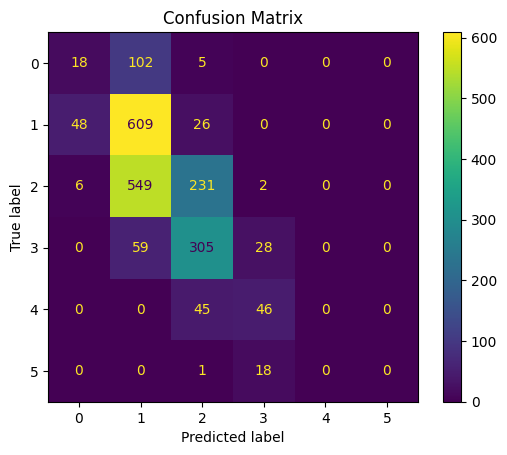

In [ ]:
cm = confusion_matrix(oof_df["score"], oof_df["pred_score"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(CFG.num_labels)))

# Plot the confusion matrix
disp.plot(cmap='viridis', values_format='d')
plt.title("Confusion Matrix")
plt.show()

## Optimal Thresholds

In [ ]:
best, threshold, xs, ys = find_thresholds(oof_df["score"] + 1, oof_df["pred_score"], steps=500)

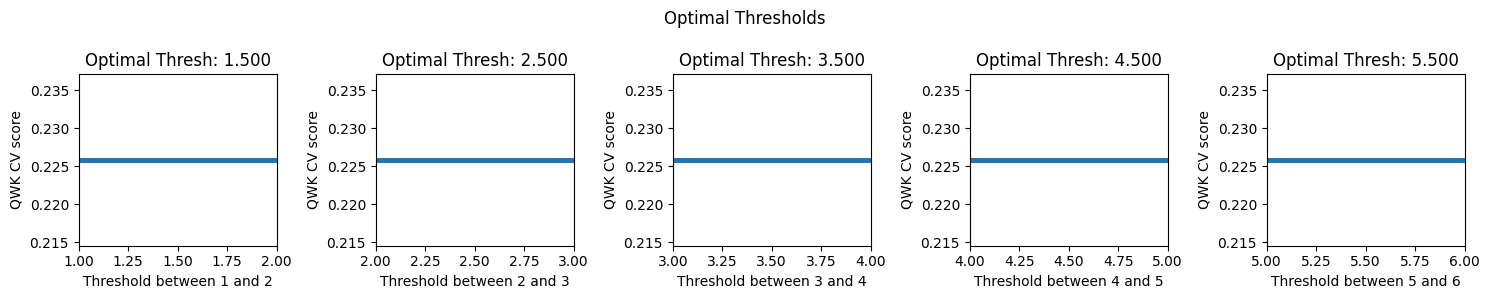

In [ ]:
diff = 0.5
nrows, ncols = 1, 5  # Define grid for 5 subplots (1 row, 5 columns)

fig, axes = plt.subplots(nrows, ncols, figsize=(15, 3))  # Create figure and subplots

# Loop through data and plot on each subplot
for k in range(5):
    ax = axes.flat[k]  # Access each subplot using flattened axes
    ax.scatter(xs[k], ys[k], s=3)
    m = k + 1.5
    ax.set_xlim((m - diff, m + diff))
    i = np.where((np.array(xs[k]) > m - diff) & (np.array(xs[k]) < m + diff))[0]
    mn = np.min(np.array(ys[k])[i])
    mx = np.max(np.array(ys[k])[i])
    ax.set_ylim((mn, mx))

    ax.plot(
        [threshold[k], threshold[k]],
        [mn, mx],
        "--",
        color="black",
        label="optimal threshold",
    )

    ax.set_title(f"Optimal Thresh: {threshold[k]:4.3f}", size=12)  # Adjust title size
    ax.set_xlabel(f"Threshold between {k+1} and {k+2}", size=10)
    ax.set_ylabel("QWK CV score", size=10)

# Common legend for all subplots
plt.suptitle("Optimal Thresholds", size=12)
plt.tight_layout()  # Adjust spacing between subplots
plt.show()

In [ ]:
with open(Paths.threshold_path, "wb") as file:
    pkl.dump(threshold, file)

## Wrapping up

In [ ]:
wandb.finish()

CV/qwk_score,▁
eval/loss,▁
eval/qwk,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇████
train/global_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇██████████████
train/grad_norm,▄▃▂▅▃▂▂▅▃▇▃▄▄▁▃▃█▂▁
train/learning_rate,▁██▇▇▆▆▆▅▅▅▄▄▃▃▃▂▂▁▁
train/loss,█▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
